In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import os

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [33]:
import seaborn as sns

sns.set_theme()
sns.set_context("paper", rc={"lines.linewidth": 2.5})

In [34]:
# Constants
K_MEANS_THRESHOLD = 20
SUPTITLE_FONTSIZE = 26
TITLE_FONTSIZE = 18

In [35]:
# Utility functions
def get_season(date):
    """
    Get the season for a given date.

    Parameters:
    - date: datetime object

    Returns:
    - season: str
    """
    if pd.isnull(date):
        return None
    
    month = date.month

    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'
    
def get_time_of_day(date):
    """
    Determines if it's day or night (0, 1)

    Parameters:
    - date: datetime object

    Returns:
    - night: float
    """
    if pd.isnull(date):
        return 1

    hour = date.hour

    day_threshold = 6 
    night_threshold = 22

    if day_threshold < hour < night_threshold:
        return 0  # Day
    else:
        return 1  # Night
  
def temperature_label(temperature):
    """
    Get temperature range for a given temperature.

    Parameters:
    - temperature: float

    Returns:
    - temperature_label: str
    """
    if pd.isnull(temperature):
        return None
    
    if temperature < -10:
        return "Extremely Cold"
    elif -10 <= temperature < 0:
        return "Cold"
    elif 0 <= temperature < 5:
        return "Cool"
    elif 5 <= temperature < 10:
        return "Slightly Warm"
    elif 10 <= temperature < 15:
        return "Moderate"
    elif 15 <= temperature < 20:
        return "Warm"
    elif 20 <= temperature < 25:
        return "Very Warm"
    elif 25 <= temperature < 30:
        return "Hot"
    elif 30 <= temperature < 35:
        return "Very Hot"
    elif 35 <= temperature < 40:
        return "Extremely Hot"
    else:
        return "Exceptionally Hot"
    
def classify_animal(animal):
    groups = {
        # Mammals
        # "mammal": ["porcupine", "wild boar", "marten", "badger", "fox", "wolf", "dog", "cat", "hare", "deer", "horse", "squirrel"],
        
        # Birds
        "bird": ["buzzard", "heron", "mallard"],
        
        # Water animals
        "water_animal": ["mallard", "heron"],
        
        # Predatory animals
        "predatory_animal": ["fox", "wolf", "buzzard"],
        
        # Domestic animals
        "domestic_animal": ["dog", "cat", "horse"],
        
        # Herbivores
        "herbivore": ["porcupine", "wild boar", "hare", "deer", "horse", "squirrel"],
        
        # Night Animals
        "night_animal": ["fox", "wolf", "hare", "badger"],
        
        # Size Classification
        "size": ["xs", "s", "m", "l"]
    }
    
    # Define size boundaries
    size_boundaries = {
        "xs": ["mallard", "buzzard", "porcupine", "marten", "cat", "hare", "squirrel"],
        "s": ["fox", "cat", "badger"],
        "m": ["heron", "dog", "wild boar","deer", "wolf"],
        "l": ["horse"]
    }
    
     # Classify based on size
    size_group = next((size for size, animals in size_boundaries.items() if animal.lower() in animals), None)
    
    # Classify based on other groups
    animal_groups = {group: 1 if animal.lower() in animals else 0 for group, animals in groups.items()}
    
    # Add size group to the result
    animal_groups["size"] = size_group
    
    return animal_groups

In [36]:
# define the direcories
images_dir = '../../images/aculei-images'
csv_dir = '../../datasets'

In [37]:
df = pd.read_pickle(csv_dir + '/animals.pkl')
df.head()

,image_name,camera,date_time,date,time,moon,temp,sha-256,label1,label2,label3
0,TF_ACULEI_8040_DSCF0129.jpg,1.0,2021-07-22 23:04:07,2021-07-22,23:04:07,Full Moon,25.0,00917733a6aa7e574a2da861dc75b70f5e38db45b50983...,wild boar,NaN,NaN
1,TF_ACULEI_900_DSCF0756.jpg,1.0,2021-05-27 22:01:44,2021-05-27,22:01:44,Full Moon,16.0,01b46bf7f72f5ecd35669d876892619192c50771d44949...,wild boar,NaN,NaN
2,TF_ACULEI_15294_DSCF0133.jpg,6.0,2023-03-30 20:35:58,2023-03-30,20:35:58,First Quarter,9.0,a4080d64cc86785ee8ab82468db78b14e4ddb9838faef6...,porcupine,badger,fox
3,TF_ACULEI_11374_DSCF0064.jpg,6.0,2022-06-09 21:29:59,2022-06-09,21:29:59,Waxing Gibbous,15.0,314a99154f1709a8a6ac99069b1af4cebf0cc9df089ce4...,fox,porcupine,wild boar
4,TF_ACULEI_4106_DSCF4336.jpg,1.0,2021-06-16 23:41:09,2021-06-16,23:41:09,First Quarter,19.0,f1c6a3c629f9fb55975f6e02eeeccbd708477ddcf574e5...,fox,None,None


In [38]:
# some type changes
df['date'] = pd.to_datetime(df['date'])
df['date_time'] = pd.to_datetime(df['date_time'])

# adding some new columns
df['season'] = df['date_time'].apply(get_season)
df['night'] = df['date_time'].apply(get_time_of_day)
df['temp'] = df['temp'].apply(temperature_label)

# Apply the function to the 'label' column and store the result in new columns
df_result = pd.DataFrame(df['label1'].apply(classify_animal).tolist())

# Concatenate the result with the original DataFrame
df = pd.concat([df, df_result], axis=1)

# Display the updated DataFrame
df.head()

,image_name,camera,date_time,date,time,moon,temp,sha-256,label1,label2,label3,season,night,bird,water_animal,predatory_animal,domestic_animal,herbivore,night_animal,size
0,TF_ACULEI_8040_DSCF0129.jpg,1.0,2021-07-22 23:04:07,2021-07-22,23:04:07,Full Moon,Hot,00917733a6aa7e574a2da861dc75b70f5e38db45b50983...,wild boar,NaN,NaN,Summer,1,0,0,0,0,1,0,m
1,TF_ACULEI_900_DSCF0756.jpg,1.0,2021-05-27 22:01:44,2021-05-27,22:01:44,Full Moon,Warm,01b46bf7f72f5ecd35669d876892619192c50771d44949...,wild boar,NaN,NaN,Spring,1,0,0,0,0,1,0,m
2,TF_ACULEI_15294_DSCF0133.jpg,6.0,2023-03-30 20:35:58,2023-03-30,20:35:58,First Quarter,Slightly Warm,a4080d64cc86785ee8ab82468db78b14e4ddb9838faef6...,porcupine,badger,fox,Spring,0,0,0,0,0,1,0,xs
3,TF_ACULEI_11374_DSCF0064.jpg,6.0,2022-06-09 21:29:59,2022-06-09,21:29:59,Waxing Gibbous,Warm,314a99154f1709a8a6ac99069b1af4cebf0cc9df089ce4...,fox,porcupine,wild boar,Summer,0,0,0,1,0,0,1,s
4,TF_ACULEI_4106_DSCF4336.jpg,1.0,2021-06-16 23:41:09,2021-06-16,23:41:09,First Quarter,Warm,f1c6a3c629f9fb55975f6e02eeeccbd708477ddcf574e5...,fox,None,None,Summer,1,0,0,1,0,0,1,s


In [39]:
# now define which columns have to be encoded and which ones are not useful
cols_to_encode = ['label1', 'season', 'temp', 'size', 'bird', 'water_animal', 'predatory_animal', 'domestic_animal', 'herbivore', 'night_animal', 'night']
cols_to_drop = ['image_name', 'date_time', 'date', 'time', 'sha-256', 'label2', 'label3', 'camera', 'moon']

df.drop(columns=cols_to_drop, inplace=True)
encoded_df = pd.get_dummies(df, columns=cols_to_encode, prefix=cols_to_encode)
encoded_df.head()

,label1_badger,label1_buzzard,label1_cat,label1_deer,label1_fox,label1_hare,label1_heron,label1_horse,label1_mallard,label1_marten,...,predatory_animal_0,predatory_animal_1,domestic_animal_0,domestic_animal_1,herbivore_0,herbivore_1,night_animal_0,night_animal_1,night_0,night_1
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,0,1,0
3,0,0,0,0,1,0,0,0,0,0,...,0,1,1,0,1,0,0,1,1,0
4,0,0,0,0,1,0,0,0,0,0,...,0,1,1,0,1,0,0,1,0,1


In [40]:
encoded_df.shape

(16874, 45)

Explained Variance Ratio: [1.91750888e-01 1.30920027e-01 9.65438968e-02 6.35446889e-02
 4.50914211e-02 3.63333130e-02 3.34671203e-02 3.01992770e-02
 2.87411952e-02 2.59292366e-02 2.54456843e-02 2.46053744e-02
 2.42749517e-02 2.36310277e-02 2.34274205e-02 2.25607487e-02
 2.23905217e-02 2.22659146e-02 2.19324528e-02 2.16759225e-02
 2.13911740e-02 2.05578962e-02 1.89832232e-02 1.40426852e-02
 7.27950375e-03 2.98948451e-03 2.49502890e-05 6.51656969e-28
 5.14406975e-28 3.94335673e-28 2.75796254e-28 2.23193300e-28
 1.51080923e-28 9.91414214e-29 9.29225086e-29 6.75435881e-29
 8.90378317e-30 2.42454172e-31 2.07036770e-31 3.78159347e-32
 9.00693694e-34 9.00693694e-34 9.00693694e-34 9.00693694e-34
 9.00693694e-34]


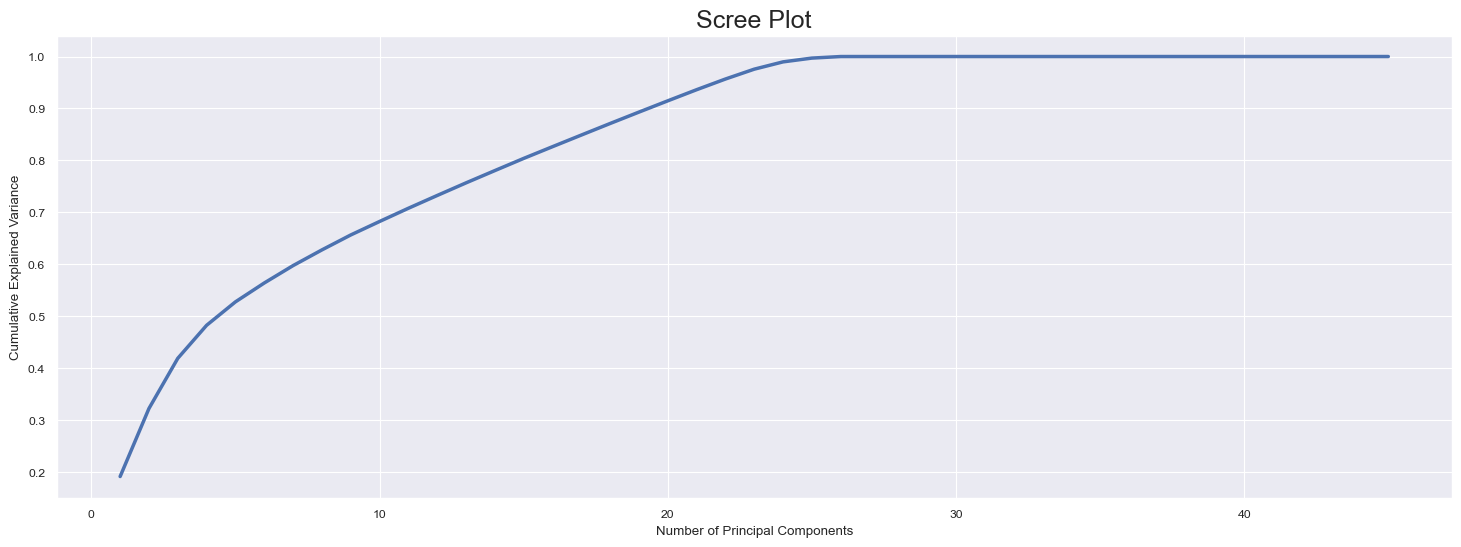

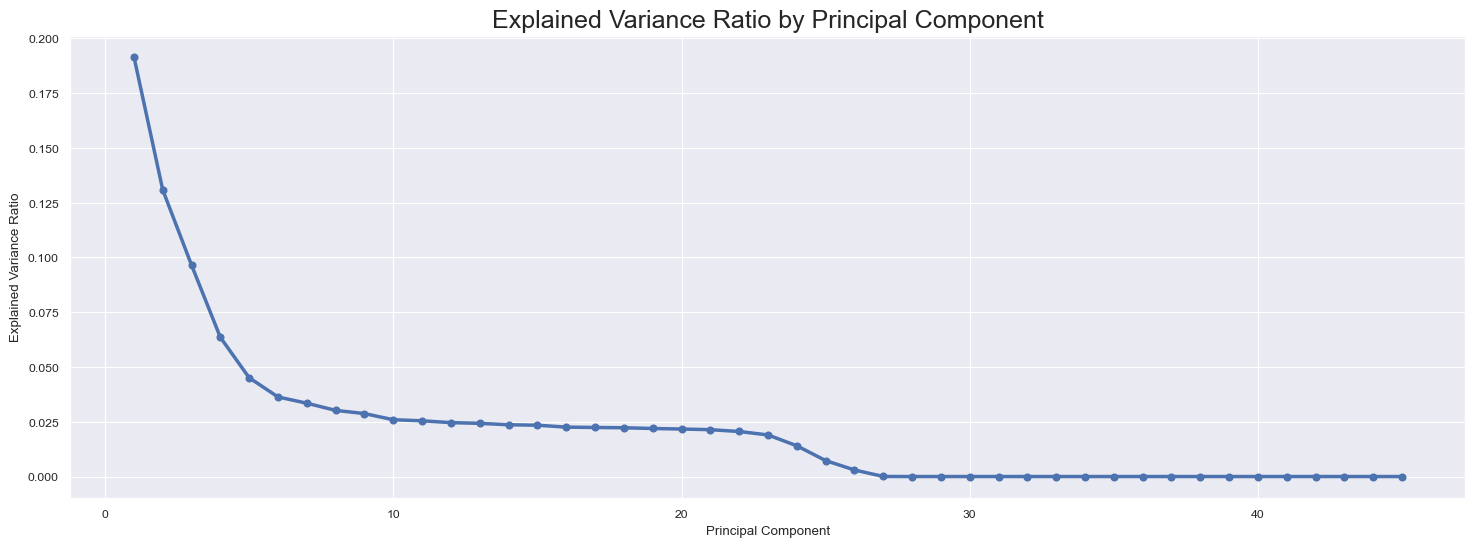

Principal Components:
[[ 6.96115890e-02  3.38661079e-02  3.77146429e-03 ...  2.92905192e-01
   9.39778869e-02 -9.39778869e-02]
 [-1.93712687e-02  5.14125666e-02  5.84523076e-03 ... -1.72325480e-01
   1.30704224e-01 -1.30704224e-01]
 [-2.67083239e-04 -7.91799730e-03  4.16509841e-02 ... -2.40545026e-02
   6.75691777e-02 -6.75691777e-02]
 ...
 [-0.00000000e+00 -6.17942670e-18  3.44491673e-18 ... -5.23886490e-15
  -7.63278329e-17 -3.64291930e-17]
 [-0.00000000e+00  8.77936923e-17 -1.87283020e-18 ...  7.51482210e-15
  -1.24900090e-16 -7.45931095e-17]
 [ 0.00000000e+00  1.80150005e-17  2.70013000e-17 ...  1.30863202e-16
   8.99616753e-17  8.80914265e-17]]
Number of components to retain for 95.0% cumulative explained variance: 22
Loadings for the first few principal components:


,label1_badger,label1_buzzard,label1_cat,label1_deer,label1_fox,label1_hare,label1_heron,label1_horse,label1_mallard,label1_marten,...,predatory_animal_0,predatory_animal_1,domestic_animal_0,domestic_animal_1,herbivore_0,herbivore_1,night_animal_0,night_animal_1,night_0,night_1
0,0.069612,0.033866,0.003771,-0.026515,0.281636,0.025530,0.042893,-0.013081,0.084358,0.028913,...,-0.285315,0.285315,0.012425,-0.012425,0.318988,-0.318988,-0.292905,0.292905,0.093978,-0.093978
1,-0.019371,0.051413,0.005845,0.016761,-0.181334,0.005907,0.189086,0.024964,0.307829,0.031442,...,0.171667,-0.171667,-0.025555,0.025555,0.011922,-0.011922,0.172325,-0.172325,0.130704,-0.130704
2,-0.000267,-0.007918,0.041651,0.018055,-0.031919,0.017675,-0.052212,0.457913,-0.053417,0.014487,...,0.033293,-0.033293,-0.459483,0.459483,-0.052429,0.052429,0.024055,-0.024055,0.067569,-0.067569
3,-0.039682,-0.002942,0.002625,-0.130188,0.107456,-0.148838,0.151410,0.157340,0.086860,-0.168222,...,-0.106889,0.106889,-0.156229,0.156229,0.084382,-0.084382,-0.037206,0.037206,-0.160090,0.160090
4,0.024367,-0.004907,-0.036796,0.323407,0.013342,-0.083992,0.104029,-0.020628,-0.089775,-0.128165,...,-0.013420,0.013420,0.025630,-0.025630,-0.035733,0.035733,0.005288,-0.005288,0.426227,-0.426227
5,-0.161815,0.072981,-0.005829,0.010424,0.053506,-0.242146,0.130236,-0.000214,0.005753,0.047491,...,-0.065809,0.065809,0.001035,-0.001035,0.053567,-0.053567,0.086656,-0.086656,-0.299645,0.299645
6,-0.470782,0.255371,-0.008395,0.029696,0.127322,-0.087207,0.020138,-0.008901,-0.023805,-0.065063,...,-0.168521,0.168521,0.010002,-0.010002,-0.039138,0.039138,0.079871,-0.079871,0.253213,-0.253213
7,-0.171017,0.141672,0.026266,0.160716,0.033221,-0.130306,-0.044401,-0.017823,-0.016495,0.121432,...,-0.061831,0.061831,0.013946,-0.013946,0.025840,-0.025840,0.067959,-0.067959,0.029296,-0.029296
8,0.119340,0.153596,0.075204,-0.241748,-0.052187,-0.319506,-0.040487,0.021838,-0.062439,0.596700,...,0.031092,-0.031092,-0.032253,0.032253,0.204086,-0.204086,0.113362,-0.113362,0.170246,-0.170246
9,-0.128354,0.158059,-0.100687,-0.358494,0.042053,0.322108,-0.056307,0.036667,0.040248,-0.349731,...,-0.058948,0.058948,-0.022103,0.022103,-0.125358,0.125358,-0.088839,0.088839,0.114210,-0.114210


In [41]:
scaler = StandardScaler()

# Extract features
features = encoded_df.copy()

# Standardize the features
features_standardized = scaler.fit_transform(features)

# Perform pca analyzing all features
pca = PCA(n_components=features.shape[1])
principal_components = pca.fit_transform(features_standardized)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

# Scree Plot
plt.figure(figsize=(18, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio))
plt.title('Scree Plot', fontsize=TITLE_FONTSIZE)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Plotting the explained variance ratio
plt.figure(figsize=(18, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title('Explained Variance Ratio by Principal Component', fontsize=TITLE_FONTSIZE)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Individual components contributions
components = pca.components_
print("Principal Components:")
print(components)

# Set a threshold for cumulative explained variance
threshold = 0.95

# Find the number of components that meet the threshold
num_components = np.argmax(np.cumsum(explained_variance_ratio) >= threshold) + 1

print(f"Number of components to retain for {threshold * 100}% cumulative explained variance: {num_components}")

# Then use this number when applying PCA
pca = PCA(n_components=num_components)
principal_components = pca.fit_transform(features_standardized)

loadings = pca.components_

# Display the loadings in a DataFrame for better readability
loadings_df = pd.DataFrame(loadings, columns=encoded_df.columns)

# Show the loadings for the first few principal components
print("Loadings for the first few principal components:")
loadings_df.head(10)

### KMeans custom distance

In [42]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def plot_kmeans(features, cluster_labels, centroids, K):
    
    # Perform PCA to reduce dimensionality to 2 components
    scaler = StandardScaler()
    features_standardized = scaler.fit_transform(features)

    # Perform PCA to reduce dimensionality
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(features_standardized)

    # Add the 'cluster' column to the reduced DataFrame
    reduced_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
    reduced_df['cluster'] = cluster_labels

    # Get distinct colors for each cluster
    cluster_colors = plt.cm.nipy_spectral(np.linspace(0, 1, K))

    # Plotting the results
    plt.figure(figsize=(18, 8))
    for cluster in range(K):
        cluster_points = reduced_df[reduced_df['cluster'] == cluster]
        
        # Plot cluster points with consistent color
        plt.scatter(cluster_points['PC1'], cluster_points['PC2'], label=f'Cluster {cluster}', color=cluster_colors[cluster], ec='b')
        
        # Plot the centroid with 'X' and consistent color
        plt.scatter(centroids[cluster, 0], centroids[cluster, 1], marker='x', color=cluster_colors[cluster], s=200)

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.title('KMeans Clustering Results', fontsize=22)
    plt.xlabel


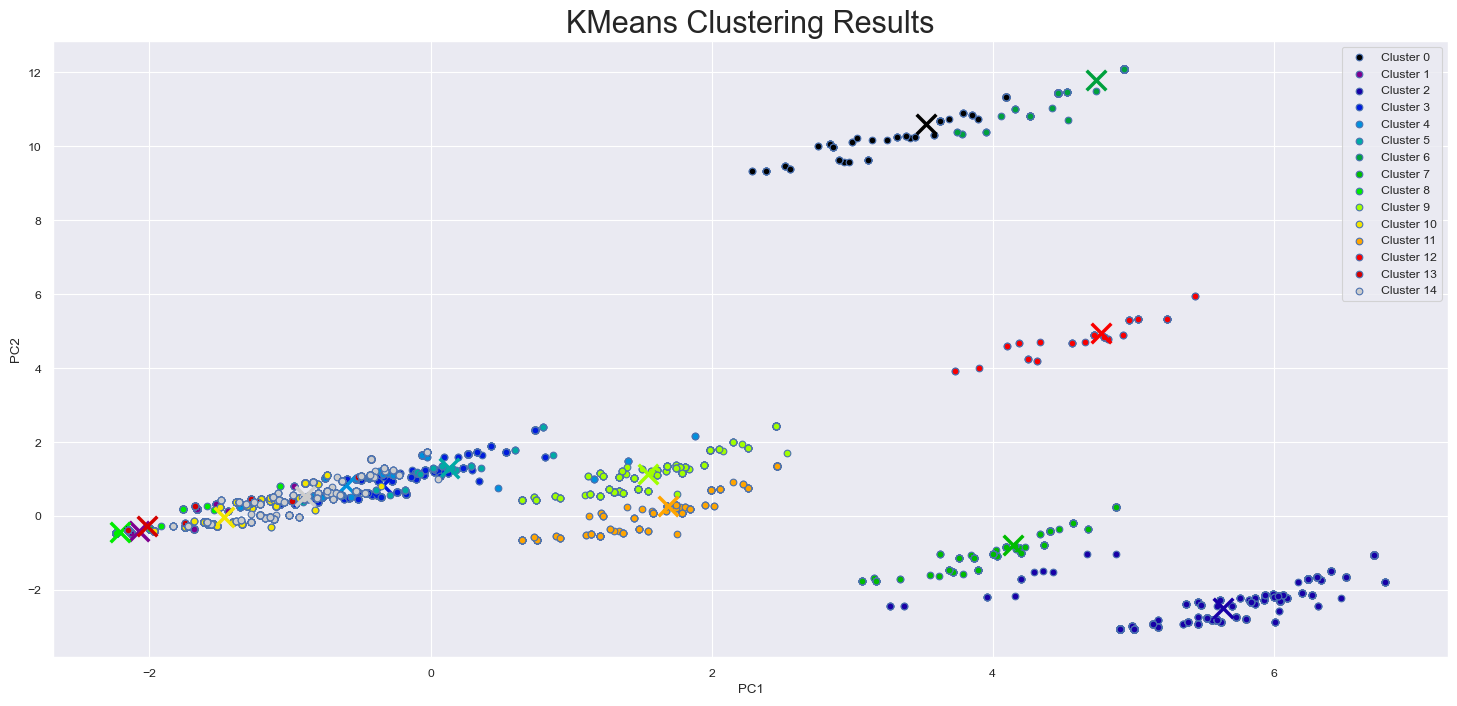

In [43]:
features = encoded_df

K = 15
model = KMeans(n_clusters=K, random_state=42)
model.fit(principal_components)
cluster_labels_pca = model.predict(principal_components)
plot_kmeans(features=features, cluster_labels=cluster_labels_pca, centroids=model.cluster_centers_, K=K)

In [44]:
# Now let's check with manhattan distance
from sklearn.metrics.pairwise import manhattan_distances

model = KMeans(n_clusters=K, random_state=42)

# Fit the model
model.fit(features)

# Calculate Manhattan distances between each data point and each cluster center
distances = manhattan_distances(features, model.cluster_centers_)

# Assign each data point to the cluster with the closest centroid
cluster_labels_pca_manhattan = np.argmin(distances, axis=1)

In [45]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

ari = adjusted_rand_score(cluster_labels_pca, cluster_labels_pca_manhattan)
print(f"Adjusted Rand Index: {ari}")

nmi = normalized_mutual_info_score(cluster_labels_pca, cluster_labels_pca_manhattan)
print(f"Normalized Mutual Information: {nmi}")

Adjusted Rand Index: 0.8065752417849742
Normalized Mutual Information: 0.8349233462073676
